# subtitle_attribution
Subtitle attribution is the ultimate goal of this module. By using various clues in the audio, video, and subtitle tracks, we were able to match onscreen characters with voices. Now we just need to go through the subtitle file and attribute each line of dialogue to the appropriate character.

In [1]:
import os
import pandas as pd
from dialogue_attribution_io import *

# Comparison with Actual Audio
We can compare the subtitles with the audio in a scene we've previously identified. This specific .wav file was extracted from the audio track and only contains audio from this scene. In another file, we've explored the `speaker_diarization()` function from the `pyAudioAnalysis` library to split the audio from a conversation into two clusters (corresponding to each speaker).

In [2]:
audio_file = ('../extracted_audio/prison_stereo.wav')

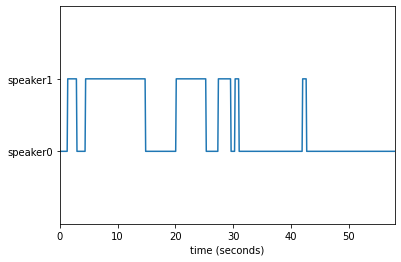

In [3]:
clusters = pyAudioAnalysis.audioSegmentation.speaker_diarization(audio_file, 2, mid_window=.8, mid_step=0.1, short_window=0.02, lda_dim=0, plot_res=True)

In [4]:
len(clusters) # 580 clusters means 58 seconds

580

# Speaker Changes
We have to work through three challenges.
1. pyAudioAnalysis' `speaker_diarization` doesn't actually tell us when someone is speaking, only the character who last spoke (whether currently speaking ot not). 
2. Frame extraction and subtitle timestamps may not line up perfectly. This is due to the issue of extracting frames from a 23.976p video.
3. Subtitles and onscreen visuals usually don't align perfectly. Subtitle authoring is more of an art than a science. They usually appear onscreen before a character actually starts speaking, but sometimes (for dramatic effect or to avoid spoiling a joke), they appear just as the character speaks.

Here are the speaker changes identified from the first 30 seconds of `speaker_diarization`. The `clusters` object contains the current or last-to-speak speaker, and reports this ten times per second. I've manually printed eight speaker changes (when the reported speaker flips from cluster 1 to 0 or 0 to 1). Remember that each item in the `clusters` list represents a tenth of a second. So a speaker change at `clusters[13]` means there's a speaker change 1.3 seconds into the scene.

In [22]:
# illustrate flip from 0 to 1 or vice versa
print('Flip A: 1.3 seconds')
for x in range(12, 14): # frame 13, or 1.3 seconds into the scene
    print(clusters[x], x)
print()
print('Flip B: 2.9 seconds')
for x in range(28, 30): # frame 29
    print(clusters[x], x)
print()
print('Flip C: 4.4 seconds')
for x in range(43, 45): # frame 44
    print(clusters[x], x)
print()
print('Flip D: 14.8 seconds')
for x in range(147, 149): # frame 148
    print(clusters[x], x)
print()
print('Flip E: 20.1 seconds')
for x in range(200, 202): # frame 201
    print(clusters[x], x)
print()
print('Flip F: 25.3 seconds')
for x in range(252, 254): # frame 253
    print(clusters[x], x)
print()
print('Flip G: 27.4 seconds')
for x in range(273, 275): # frame 274
    print(clusters[x], x)
print()
print('Flip H: 29.6 seconds')
for x in range(295, 297): # frame 296
    print(clusters[x], x)

Flip A: 1.3 seconds
0.0 12
1.0 13

Flip B: 2.9 seconds
1.0 28
0.0 29

Flip C: 4.5 seconds
0.0 43
1.0 44

Flip D: 14.6 seconds
1.0 147
0.0 148

Flip E: 20.1 seconds
0.0 200
1.0 201

Flip F: 25.3 seconds
1.0 252
0.0 253

Flip G: 27.4 seconds
0.0 273
1.0 274

Flip H: 29.6 seconds
1.0 295
0.0 296


This cluster flip searching will be be defined as a function in `dialogue_attribution_io.py` called `get_cluster_changes()`:

In [19]:
prev_clust = 200
index = 0
cluster_change_indices = []

for clust in clusters:
    if clust != prev_clust and index != 0:
        cluster_change_indices.append(index)
    prev_clust = clust
    index += 1

In [24]:
cluster_change_indices[0:8]

[13, 29, 44, 148, 201, 253, 274, 296]

In this example scene, I've manually looked at the .srt file and transcribed the speaker for the first 30 seconds. Since the audio file is only from this scene (and not the entire film), it start at 00:00:00; I've subtracted 00:12:46 from the subtitle times and wrote when they occur in the audio file. I've added commentary to how the 0-1 flips in `clusters` compare.

`Helen Mirren:  12:47.7-12:49.1    :01.7-:03.1` A: Flips .4 seconds early

`Jason Statham: 12:49.1-12:51.1    :03.1-:05.1` B: Flips .2 seconds early

`Helen Mirren:  12:51.1-13:00.6    :05.1-:14.6` C: Flips .6 seconds early

`Jason Statham: 13:00.6-13:02.3    :14.6-:16.3` D: Flips exactly on time

`No subtitle:   13:02.3-13:05.2    :16.3-:19.2` (Correctly) doesn't flip

`Helen Mirren:  13:05.2-13:12.1    :19.2-:26.1` E: Flips .9 seconds late

`Jason Statham: 13:12.1-13:13.7    :26.1-:27.7` F: Flips .8 seconds early

`Helen Mirren:  13:13.7-13:15.7    :27.7-:29.7` G: Flips .8 seconds early

`Simulteanous:  13:15.7-13:17.7    :29.7-:31.7` H: Flips .1 seconds early, but the subtitles here are ambigious since they contain one line of dialogue for each character.

Comparing the `clusters` from `voice_diarization()` to the actual subtitles, it looks like the clusters indicate speaker changes a little bit earlier than the subtitles. There is one exception, Flip E, which comes in .9 seconds late - this is probably because Helen Mirren's line starts with a curt and quiet "well", before continuing with the rest of her dialogue.

# Subtitle Times

In [7]:
sub_file = '../subtitles/hobbs_shaw.srt'
subs = load_subtitles(sub_file)

We need to calculate the times of each cluster flip. As a reminder, the `pysrt` library works with `time` objects, not `datetime` objects. First we'll calculate the time of the first frame into a `time` object using the previously-defined `frame_to_time()` function. We'll then convert that into a `datetime` object, so we can conduct arithemetic operation (not possible on time objects. Then, we'll use each cluster flip as a `timedelta`, and add it to the scene start time.  

An example for one cluster flip is shown below.

In [61]:
scene_start_time = frame_to_time(766)
scene_start_time

datetime.time(0, 12, 46)

In [50]:
scene_start_datetime = datetime.datetime(year=2000, month=1, day=1, hour=scene_start_time.hour, minute=scene_start_time.minute, second=scene_start_time.second)

In [51]:
cluster_change_indices[0]

13

Since each item in `clusters` represents a tenth of a second, we divide the cluster change index by ten, to be used as a `timedelta`.

In [53]:
cluster_flip = datetime.timedelta(seconds=cluster_change_indices[0] / 10)
cluster_flip

datetime.timedelta(seconds=1, microseconds=300000)

In [54]:
flip_datetime = scene_start_datetime + cluster_flip
flip_datetime

datetime.datetime(2000, 1, 1, 0, 12, 47, 300000)

In [55]:
flip_time = datetime.time(hour=flip_datetime.hour, minute=flip_datetime.minute, second=flip_datetime.second, microsecond=flip_datetime.microsecond)
flip_time

datetime.time(0, 12, 47, 300000)

We can perform this for all the cluster flips, though we're only interested in the first 9, the first 30 seconds' worth. This calculation of all the times when the speaker changes will be be defined as a function in `dialogue_attribution_io.py` called `get_subtitle_flip_times()`:

In [123]:
scene_start_time = frame_to_time(766)
flip_times = []
for cluster_change in cluster_change_indices:
    scene_start_datetime = datetime.datetime(year=2000, month=1, day=1, hour=scene_start_time.hour, minute=scene_start_time.minute, second=scene_start_time.second)
    cluster_flip = datetime.timedelta(seconds=cluster_change / 10)
    flip_datetime = scene_start_datetime + cluster_flip
    flip_time = datetime.time(hour=flip_datetime.hour, minute=flip_datetime.minute, second=flip_datetime.second, microsecond=flip_datetime.microsecond)
    flip_times.append(flip_time)

In [124]:
flip_times[0:8]

[datetime.time(0, 12, 47, 300000),
 datetime.time(0, 12, 48, 900000),
 datetime.time(0, 12, 50, 400000),
 datetime.time(0, 13, 0, 800000),
 datetime.time(0, 13, 6, 100000),
 datetime.time(0, 13, 11, 300000),
 datetime.time(0, 13, 13, 400000),
 datetime.time(0, 13, 15, 600000)]

We now have a list of all the times the speaker changes (according to the audio track), but as we realized above, this doesn't line up with the subtitles file.  These are the subtitles that we're looking for:

`Helen Mirren:  12:47.7-12:49.1    :01.7-:03.1 A: Flips .4 seconds early, "That's my boy."`

`Jason Statham: 12:49.1-12:51.1    :03.1-:05.1 B: Flips .2 seconds early  "No wonder we left"`

`Helen Mirren:  12:51.1-13:00.6    :05.1-:14.6 C: Flips .6 seconds early  "She loves you, you know"`

`Jason Statham: 13:00.6-13:02.3    :14.6-:16.3 D: Flips exactly on time   "Used to."`

`No subtitle:   13:02.3-13:05.2    :16.3-:19.2 (Correctly) doesn't flip`

`Helen Mirren:  13:05.2-13:12.1    :19.2-:26.1 E: Flips .9 seconds late   "Well, one day, I just hope"`

`Jason Statham: 13:12.1-13:13.7    :26.1-:27.7 F: Flips .8 seconds early  "How many years you got left?"`

`Helen Mirren:  13:13.7-13:15.7    :27.7-:29.7 G: Flips .8 seconds early  "Two, with good behavior"`

`Simulteanous:  13:15.7-13:17.7    :29.7-:31.7 H: Ambiguous subtitles     "-So how many, really?"`

In [84]:
# these are mostly incorrect
for time in flip_times[0:8]:
    print(subs.at(time).text)
    print()

(laughs)

That's my boy.

No wonder we left
the family business.

Used to.

Well, one day, I just hope
that I walk through that door

and I see the two of you
sitting there.

How many years you got left?

Two, with good behavior.



## Time Offset
We've previously defined functions that will allow us to add or subtract a time offset, to try and align the subtitles correctly.

In [9]:
flip_time = datetime.time(0, 12, 47, 300000)
offset_time = add_time_offset(flip_time, 400)
offset_time

datetime.time(0, 12, 47, 700000)

In [10]:
flip_time = datetime.time(0, 12, 47, 300000)
offset_time = subtract_time_offset(flip_time, 400)
offset_time

datetime.time(0, 12, 46, 900000)

With these, we can offset the time we search for subtitles. Here's an example of offsetting the first flip time by half a second, to get the correct subtitle.

In [64]:
subs.at(flip_times[0]).text

'(laughs)'

In [68]:
subs.at(add_time_offset(flip_times[0], 500)).text

"That's my boy."

Using list comprehension, we add an offset of .8 seconds to all the flip times.

In [81]:
offset_flip_times = [add_time_offset(flip_time, offset=800) for flip_time in flip_times]
offset_flip_times

[datetime.time(0, 12, 48, 100000),
 datetime.time(0, 12, 49, 700000),
 datetime.time(0, 12, 51, 200000),
 datetime.time(0, 13, 1, 600000),
 datetime.time(0, 13, 6, 900000),
 datetime.time(0, 13, 12, 100000),
 datetime.time(0, 13, 14, 200000),
 datetime.time(0, 13, 16, 400000),
 datetime.time(0, 13, 17, 100000),
 datetime.time(0, 13, 17, 800000),
 datetime.time(0, 13, 28, 800000),
 datetime.time(0, 13, 29, 500000)]

In [83]:
# these are all correct
for time in offset_flip_times[0:8]:
    print(subs.at(time).text)
    print()

That's my boy.

No wonder we left
the family business.

She loves you, you know.

Used to.

Well, one day, I just hope
that I walk through that door

How many years you got left?

Two, with good behavior.

-So how many, really?
-Four.



## Subtitle Attribution
We've gotten the correct subtitles for all flip times. Next, we just have to collect all the subtitles, including the ones between these flip times. Here are the indices where we've identified the flips.

In [112]:
subtitle_flip_indices = []
for time in offset_flip_times[0:8]:
    subtitle_flip_indices.append(subs.at(time)[0].index)
subtitle_flip_indices

[265, 266, 267, 271, 272, 274, 275, 276]

For example, `subs[265]` belongs to character T, `subs[266]` belongs to character S, and `subs[267]` through `subs[270]` belongs to character T. We build a list for each character containing the index for each of their subtitle lines. This will be be defined as a function in `dialogue_attribution_io.py` called `attribute_subs()`.

In [115]:
character_s_subs = []
character_t_subs = []
character = 1 # since we're just working with two-character scenes for now, this value flips between 1 and -1
sub_index_start = subtitle_flip_indices[0]
sub_index_finish = subtitle_flip_indices[-1] # this discards final subtitles, for now

for index in range(sub_index_start, sub_index_finish):
    if index in subtitle_flip_indices:
        character *= -1
    if character == 1:
        character_s_subs.append(index)
    if character == -1:
        character_t_subs.append(index)    
    
print(character_s_subs)
print(character_t_subs)

[266, 271, 274]
[265, 267, 268, 269, 270, 272, 273, 275]


In [121]:
character_s_lines = []
for index in character_s_subs:
    character_s_lines.append(subs[index].text)
character_s_lines

['No wonder we left\nthe family business.',
 'Used to.',
 'How many years you got left?']

In [122]:
character_t_lines = []
for index in character_t_subs:
    character_t_lines.append(subs[index].text)
character_t_lines

["That's my boy.",
 'She loves you, you know.',
 'All you got to do is\npick up the phone, Decks.',
 "Look at me.\nYou're her big brother.",
 'She looks up to you.',
 'Well, one day, I just hope\nthat I walk through that door',
 'and I see the two of you\nsitting there.',
 'Two, with good behavior.']

This gives us lists for each character, each containing the subtitle lines for each characters. Development on this module will pause for now, since there's some difficulty in merging these lists with the one-second-per-frame DataFrame. That DataFrame and the subtitles operate on a different time system, and the time offset introduces another headache.